In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()
Random_layer = ['bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.1.output.dense.weight',
 'bert.encoder.layer.1.output.dense.bias',
 'bert.encoder.layer.2.output.dense.weight',
 'bert.encoder.layer.2.output.dense.bias',
 'bert.encoder.layer.3.output.dense.weight',
 'bert.encoder.layer.3.output.dense.bias',
 'bert.encoder.layer.4.output.dense.weight',
 'bert.encoder.layer.4.output.dense.bias',
 'bert.encoder.layer.5.output.dense.weight',
 'bert.encoder.layer.5.output.dense.bias',
 'bert.encoder.layer.6.output.dense.weight',
 'bert.encoder.layer.6.output.dense.bias',
 'bert.encoder.layer.7.output.dense.weight',
 'bert.encoder.layer.7.output.dense.bias',
 'bert.encoder.layer.8.output.dense.weight',
 'bert.encoder.layer.8.output.dense.bias',
 'bert.encoder.layer.9.output.dense.weight',
 'bert.encoder.layer.9.output.dense.bias',
 'bert.encoder.layer.10.output.dense.weight',
 'bert.encoder.layer.10.output.dense.bias',
 'bert.encoder.layer.11.output.dense.weight',
 'bert.encoder.layer.11.output.dense.bias',
 'bert.encoder.layer.12.output.dense.weight',
 'bert.encoder.layer.12.output.dense.bias',
 'bert.encoder.layer.13.output.dense.weight',
 'bert.encoder.layer.13.output.dense.bias',
 'bert.encoder.layer.14.output.dense.weight',
 'bert.encoder.layer.14.output.dense.bias',
 'bert.encoder.layer.15.output.dense.weight',
 'bert.encoder.layer.15.output.dense.bias',
 'bert.encoder.layer.16.output.dense.weight',
 'bert.encoder.layer.16.output.dense.bias',
 'bert.encoder.layer.17.output.dense.weight',
 'bert.encoder.layer.17.output.dense.bias',
 'bert.encoder.layer.18.output.dense.weight',
 'bert.encoder.layer.18.output.dense.bias',
 'bert.encoder.layer.19.output.dense.weight',
 'bert.encoder.layer.19.output.dense.bias',
 'bert.encoder.layer.20.output.dense.weight',
 'bert.encoder.layer.20.output.dense.bias',
 'bert.encoder.layer.21.output.dense.weight',
 'bert.encoder.layer.21.output.dense.bias',
 'bert.encoder.layer.22.output.dense.weight',
 'bert.encoder.layer.22.output.dense.bias',
 'bert.encoder.layer.23.output.dense.weight',
 'bert.encoder.layer.23.output.dense.bias',
 'qa_outputs.weight',
 'qa_outputs.bias']


   #if name == 'bert.encoder.layer.21.output.dense.weight':
        #temp = torch.rand(1)

        #param.data[0] = temp
        #print(param.data[0])

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits


def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values


fig = plt.figure()
fig.set_size_inches(8, 6)

ref_token_id = tokenizer.pad_token_id  # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id  # A token used for prepending to the concatenated question-text word sequence


def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def predict_qt(question, text):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id,
                                                                cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'

    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)

    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens,


def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores,
            ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                        token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    # print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    # print("all tokens:    ", len(all_tokens))

    return all_tokens, attributions_start_sum


def get_posneg(all_tokens, attributions_start_sum):
    positive = []
    negative = []
    neutral = []
    for i, j in enumerate(attributions_start_sum):
        if j > 0:
            positive.append(i)
            # print('positive:',j)
        ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            # print('negative:',j)
            # print(all_tokens[i])
        elif j == 0:
            neutral.append(i)

    s_pos = ''
    s_neg = ''

    # print(len(attributions_start_sum))
    # print(len(positive))
    # print(len(negative))

    for i in positive:
        s_pos += all_tokens[i] + ' '
    # print("positive :", s_pos)
    for i in negative:
        s_neg += all_tokens[i] + ' '
    # print("negative :", s_neg)
    return positive, negative, neutral


def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[CLS]":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num + 1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num + 1
        else:
            temp.append(all_tokens[i])
    return sentence


def get_sence_score(sentence, attributions_start_sum):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = []
    for k, v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores = {}

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight += scores[word]
        delete_sentence.append(sum_weight)
        # print(sum_weight)
    return delete_sentence


def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = {}
    for k, v in sentence.items():
        # print(k,':',v)
        for i in v:
            sentence_value.append(i)
    # print(sentence_value)
    scores = {}
    # print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight += scores[word]
            delete_sentence[i] = sum_weight
    return delete_sentence


def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence


def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word
            rebuild_str += " "
    return rebuild_str


def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, = predict_qt(
        text, question)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask,
                                                 start_scores, end_scores, ground_truth, all_tokens, )

    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    return all_tokens, attributions_start_sum, end_score, start_score, [torch.argmax(start_scores), torch.argmax(
        end_scores) + 1], start_scores, end_scores


def max_min(x, y, z):
    max = min = x
    i = 1
    if y > max:
        max = y
        i = 2
    else:
        min = y
    if z > max:
        max = z
        i = 3
    else:
        min = z
    return (i)


def cycle_prediction(cycle_num, question, text):
    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(text,
                                                                                                              question)
    first_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
    first_answer = re.sub(r' ##', '', first_answer)
    print("my answer is ", first_answer)
    print(start_acc, end_acc)
    second_answer = ''
    sentence = separate_sentence(all_tokens)
    a = 0
    pos_contri = 0
    neg_contri = 0
    average_neg = []
    average_pos = []
    for i, j in enumerate(attributions_start_sum):
        if j < 0:
            neg_contri += j
        elif j > 0:
            pos_contri += j
    print("positive contribution:", pos_contri)
    average_pos.append(pos_contri)
    print("negative contribution:", neg_contri)
    average_neg.append(neg_contri)

    acc_s = []
    acc_e = []
    sun = []
    ans = []
    ans.append(first_answer)
    # print(start_acc, end_acc)
    acc_s.append(start_acc)
    acc_e.append(end_acc)

    for loop in range(cycle_num):
        sentence = separate_sentence(all_tokens)
        sentence_score = get_sence_score(sentence, attributions_start_sum)
        min_sensocer = 999
        min_index = 999
        for i in range(len(sentence_score)):
            if sentence_score[i] < min_sensocer and sentence_score[i] != 0:
                min_sensocer = sentence_score[i]
                min_index = i
        # print("should delete", min_index, min_sensocer)
        sentence[min_index] = ''
        sentence[1] = ''
        retext = ""
        for i, j in sentence.items():
            for words in j:
                retext = retext + words + " "
        li_sep = []
        for m in re.finditer(r"SEP", retext):
            li_sep.append(m.start())
            li_sep.append(m.end())
        retext = retext[li_sep[1] + 1: li_sep[2] - 1]
        retext = re.sub(r' ##', '', retext)

        all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(
            retext, question)
        reanswer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        # print(start_acc, end_acc)
        second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        second_answer = re.sub(r' ##', '', second_answer)
        # print("my answer is ", second_answer)
        ans.append(second_answer)
        # print(start_acc, end_acc)
        acc_s.append(start_acc)
        acc_e.append(end_acc)
        pos_contri = 0
        neg_contri = 0
        for i, j in enumerate(attributions_start_sum):
            if j < 0:
                neg_contri += j
            elif j > 0:
                pos_contri += j
        print("positive contribution:", pos_contri)
        average_pos.append(pos_contri)
        print("negative contribution:", neg_contri)
        average_neg.append(neg_contri)

        # print(acc_s, acc_e)
        # print(acc_s, acc_e)
    plt.plot(range(len(acc_s)), acc_s, label='start score')
    plt.plot(range(len(acc_s)), acc_e, label='end score')
    sun = []
    for i in range(len(acc_s)):
        sun.append((acc_s[i] + acc_e[i]) / 2)
    print(sun)
    plt.plot(range(len(acc_s)), sun, label='average')
    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()

    """"获取最好的曲线并输出"""
    max_start = 0
    max_end = 0
    max_ave = 0
    for i in acc_s:
        if i > max_start:
            max_start = i
    for j in acc_e:
        if j > max_end:
            max_end = i

    for x in sun:
        if x > max_ave:
            max_ave = x

    print(max_start, max_end, max_ave)

    max_list = max_min(max_start, max_end, max_ave)
    if max_list == 1:
        plt.plot(range(len(acc_s)), acc_s, label='Possibility')
        print(acc_s)
    if max_list == 2:
        plt.plot(range(len(acc_e)), acc_e, label='Possibility')
        print(acc_e)
    if max_list == 3:
        plt.plot(range(len(sun)), sun, label='Possibility')
        print(sun)

    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()
    """贡献的数值分别是多少"""
    plt.plot(range(len(average_pos)), average_pos, label='pos score')
    plt.plot(range(len(average_neg)), average_neg, label='neg score')
    plt.xlabel('Number of predictions')
    plt.ylabel('average contribution of pos/neg')
    plt.legend()
    plt.show()
    for i in range(len(ans)):
        print(ans[i], "pos/neg : ", -(average_pos[i] / average_neg[i]))
    average_contribution = 0

def random_model():
    text = """One of the first Norman mercenaries to serve as a Byzantine general was Hervé in the 1050s. By then however, there were already Norman mercenaries serving as far away as Trebizond and Georgia. They were based at Malatya and Edessa, under the Byzantine duke of Antioch, Isaac Komnenos. In the 1060s, Robert Crispin led the Normans of Edessa against the Turks. Roussel de Bailleul even tried to carve out an independent state in Asia Minor with support from the local population, but he was stopped by the Byzantine general Alexius Komnenos."""

    question = """When did Herve serve as a Byzantine general?"""

    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(text,
                                                                                                              question)

    attr_nomal = []
    for i, j in enumerate(attributions_start_sum):
        attr_nomal.append(j.item())
    print(attr_nomal)
    return attr_nomal

random_attribution = []
for i in range(int((len((Random_layer)))/2)):
    for name, param in model.named_parameters():
        if name in Random_layer[0:i*2]:
            param.data = torch.rand(param.size())
            model.to(device)
    random_attribution.append(random_model())
    print(i)
print("随机的贡献分别都是：", random_attribution)


Question:  When did Herve serve as a Byzantine general?
Predicted Answer:  105 ##0s
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.8690725593657715, 0.2337344599471851, 0.08005030041046007, 0.08864003335387671, 0.09622049285690962, 0.07697813848835218, 0.07482073658094374, 0.04559544460193606, 0.10520598097002073, 0.18155816811190606, 0.0, 0.05300490888385318, 0.030023930870179124, 0.022066999182590766, 0.010587985860722043, 0.005653058476815085, 0.029871337975542242, 0.05863688385867519, -0.00043634941859846974, -0.02862715562418831, 0.00852400385887852, 0.045736538819464496, 0.08791900854101879, 0.0395702148870914, 0.1043501888558295, 0.1829468583847028, 0.023088798383675273, 0.018909515327637526, 0.030915791248510485, 0.060988844692462595, 0.02191176346857275, 0.04448626623573387, -0.044658809874091834, -0.00106241259290115, 0.03263529624756706, -0.014580989233784064, 0.007146297453800516, 0.0013162197297505488, 0.02254904430500845, 0.049720185360321606, 0.02409861623425201, -0.0032579464446175835, 0.02268272989247543, 0.024725443083509987

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.05041351511966955, -0.04712578553938644, 0.09384614552990958, 0.01342626564321371, 0.03077430609490689, -0.021850228550979532, 0.013848832127837777, 0.10757880419525848, -0.10062887433394065, -0.013866437621978296, 0.0, -0.04129417528360778, -0.02101356159144251, -0.04397762396400081, -0.019042122279480826, 0.041381726297536864, 0.10205320772277528, 0.021914916917345324, -0.06802041896656895, -0.06223047992952961, -0.04933832466499838, -0.07150950212293755, -0.024577493913296517, -0.019391361207414852, -0.04819916079379332, 0.09214173087315088, -0.019108096203222274, 0.012689337151081148, -0.036711668177842785, 0.062398380579478524, -0.06581803232343261, 0.03466704005111578, -0.12237472947924295, -0.01687758617208802, 0.2536686746863188, 0.02867715471058825, 0.07741373068579077, -0.07040244184520583, 0.09889962759400454, 0.2081326677098391, -0.07941837938210229, -0.07143090235260638, -0.058698514544411544, -0.025

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.20683199683482936, -0.02756204756085253, -0.007192920970789538, -0.17522165864204967, -0.12798409095891436, -0.09266620423053498, 0.03072136787515034, 0.10670447328430531, -0.049347690393077535, 0.0983890464178611, 0.0, -0.07478383058245314, -0.14236957086182414, 0.05135060880557189, -0.04521744471994821, 0.001315454475194884, -0.004755264484089835, 0.0071414287916506045, 0.04963470510572805, -0.20109123213482114, 0.042801844623317015, -0.013665203058306414, 0.007240860767116931, -0.10945338912902815, -0.06244257578231927, 0.0026391326383225014, 0.027046320351741787, 0.015104289326967769, 0.05646317711826886, -0.12222617914666899, 0.04947667101132813, -0.10280924159591241, 0.0705971728061402, 0.25291443621788223, -0.10887590978009316, 0.1667298114950593, 0.005603303122449564, 0.09931123981445981, -0.04105832100106104, -0.04693549322533766, 0.09901256225226782, -0.10416136187405889, 0.022248334366986977, 0.00944782

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.06945653329669628, 0.005896500507831333, 0.03814814519321918, 0.0008252500847614003, 0.11260818168135789, 0.02020575158890966, -0.11307536518396663, -0.03432401740394692, 0.15342206017318477, 0.059378114388977346, 0.0, -0.06985929879377975, -0.038091388316894834, 0.07162285991701793, -0.08746799861608259, -0.05958997691414862, -0.08903711746834886, 0.057329338163077975, 0.01437371638263357, 0.01387933263064923, -0.03706850821360174, -0.1487837838988876, -0.07387420448616318, -0.054576139866243996, 0.07341512290144765, -0.03262891082530377, 0.012890088427145249, 0.05007340109004896, 0.10846322066743502, 0.06595449632792624, 0.05342264309406869, -0.02501142728765253, 0.007720517446099064, 0.16329602682037364, 0.09324400451559223, -0.008082051045354937, 0.09861471477278265, 0.10834296598209797, -0.08342217198500408, -0.030713815908592686, 0.023942845307430467, 0.12506146749714808, 0.01878799815592765, 0.056425303712

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.030906598883789608, 0.017060794059514713, 0.006816828382247782, 0.04996324381210982, 0.01566154899277406, 0.07266562731046858, 0.007886701320350251, -0.02565201880806199, 0.01166500482450752, 0.027606120262024882, 0.0, 0.009748167201911519, -0.040240590314068625, 0.03349237257799507, -0.045339928718416474, -0.07676853712097266, -0.007952845269174402, -0.011515116235888662, 0.004206075225891491, -0.05901928381590503, 0.04901886128553766, 0.08202409188087943, -0.0883794046186543, 0.03174419213893303, 0.012959570757289068, 0.014015767111816398, 0.03227102118972609, 0.08268341081797007, 0.03199609977004162, 0.0004857686218968358, -0.04956365435961545, -0.045758735915813926, -0.008712587831869194, -0.0015847014454956959, 0.018559410064438318, 0.06245543758112676, 0.004752611282244253, -0.021127200883902922, -0.04366660899573914, -0.013913363668884102, 0.027661981357115804, -0.007432818308181979, 0.013325705880115047, 0

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.07959383261329127, 0.08900659590741294, 0.16997587619871915, -0.03313408875155955, -0.1232715653326237, 0.06546043639755185, -0.06623545028715755, 0.07938407468517333, -0.1721757863140021, -0.15992295257078665, 0.0, -0.09320380563405312, -0.20522454881757557, -0.03152510944368041, -0.11108096658281462, 0.04528326277029206, 0.16688600404478, -0.008254677510686653, -0.19537446753987925, 0.04377623679259116, -0.12423551589039919, -0.03793569910455662, 0.05364614970717769, 0.053668783845854565, -0.03524218258510346, -0.08048344043577843, 0.05921453747071985, -0.043130620033824243, 0.0760483680107918, -0.09297489911447675, -0.027722479296719414, -0.06621290560451301, 0.1593282356912377, 0.0028437619000256905, 0.014723033829755088, 0.028446512758237976, 0.03502737433449262, -0.11227309442149558, 0.11642043406771667, 0.18547877010602354, -0.03557195822883986, 0.024480009729084443, 0.006422380107247268, 0.0501436460047951

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.298389966478562, 0.09343010437813233, 0.11633343835344746, 0.030061851991409018, -0.033937375863162894, 0.1662306597241561, -0.09945332919180262, 0.17105389745239594, 0.0004873040564625898, 0.08006739103819598, 0.0, 0.0276707419854671, 0.04858580051102586, -0.04118238127205438, 0.0766307010332088, -0.023190494774908352, -0.13647568344608796, 0.10891823924391413, 0.02228500749026547, 0.033483730538680576, 0.07281804384926471, -0.07847730821867929, -0.05446148647300648, -0.016258741957872483, 0.1244001108768112, 0.012988668177905912, 0.009386457460103909, -0.0006380466241876256, 0.02244552362862527, 0.12619885880849596, -0.042575535972459264, -0.01869797823325794, 0.05168896435748486, -0.00110238522736451, -0.035595134827096586, 0.09324776995266944, 0.007582914961455632, 0.07585172267895798, 0.03648377778979402, 0.03753209888344849, 0.021215143056095384, 0.011569407560468403, 0.05291809844496573, 0.07791085069075496

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.03754339373423444, -0.14216741104508435, -0.02294074554162026, -0.005864196267994028, -0.054251567357586655, 0.03818069637349419, 0.10243983986013179, 0.15144655622866632, -0.07881458844160064, 0.12551744518617852, 0.0, -0.013258902358151307, 0.14059756822223304, 0.07812209850517977, -0.1308446305006227, 0.00867066545374739, 0.008959413774852244, 0.0355680606333324, 0.12251828218950549, -0.019402797495112267, 0.005672228942012988, 0.11211427298951196, -0.031065434942008873, -0.019188844960474318, 0.007846982626188615, -0.11768668706463652, 0.024158489795811113, -0.010501497742591752, -0.21569362580568277, -0.055830625648099326, -0.06941859996861614, -0.04178293539742472, -0.12061212453488283, 0.06082247341169617, -0.054541038470562596, 0.028471656061357944, -0.04362836420533916, -0.15082830362769267, -0.10914277338676387, 0.16908570162293735, -0.02155831482636785, 0.008620036127311525, 0.11111823343694437, 0.04810

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.2748926521094561, 0.004530270096140415, -0.09552609382560277, 0.013702487126421673, 0.01850912519629985, 0.04865624491992119, -0.013864769419658848, 0.31194931600372117, -0.033986910708478923, -0.08747940694404498, 0.0, -0.09104219446317763, -0.14587122369017483, 0.0058372761041586355, 0.0069587470262144815, -0.07231162524605647, 0.10424417852006312, 0.08971667143846705, 0.06497682501802875, -0.05004796007821114, 0.021840351749061394, 0.08317438496543464, -0.04625654349074905, -0.031752647486514914, -0.019709173983745335, 0.015620976695557169, 0.14356733783933712, 0.016562917788632, 0.014670978258978182, 0.12247503923896431, -0.029009675542019338, -0.005790785793553594, -0.010783393778548632, 0.033542448859986584, -0.07151034061874978, 0.21424026745128427, 0.1382829676185731, 0.008998622499901316, 0.036812514747673664, 0.06781122290676525, -0.02031760550460972, -0.009633303397512956, 0.0309990504264208, -0.058615

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.1718009222376471, -0.09316491578905114, 0.07451042937057702, 0.06025511968426975, -0.12631867710188655, 0.024942103499019236, -0.01540960521289723, -0.01991492857528907, 0.12268442560936928, 0.20668975370269327, 0.0, 0.20753083786046705, 0.07596198837469663, 0.05404573380282556, -0.019735569119243186, -0.05763663259645084, -0.1836696424152259, 0.10451704865670441, 0.08756622797039927, -0.08542411374410377, -0.024026700174689053, -0.12729057067936597, 0.03268888233696544, 0.16389349893941438, 0.004831089882336654, 0.0799400197144646, 0.021796740221171756, -0.04402178230334221, 0.009423366104355279, -0.015111222550020363, 0.1441740161596815, 0.13027983844602534, 0.06237692498035156, -0.053986545755291056, 0.11407659374501687, -0.0014689383198431653, -0.07751855265218055, -0.10403663803414329, -0.06437525755229581, -0.1768232035142548, 0.1819668046204685, 0.09231521117496728, -0.12916516752566076, 0.04548941666007787

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.06100544649995373, 0.09037822017007743, -0.0650576344283608, 0.057458517984161635, -0.052940098450685515, 0.06340928600188575, -0.09011384009541094, 0.049262900807201325, 0.0957241920383798, -0.07536427931923106, 0.0, -0.08648757251675926, 0.05840636172606131, 0.01952016424804473, 0.09145487699840604, -0.03372329480931683, 0.13251998160963324, -0.006954210723267717, -0.012142669456027332, -0.035401842353973124, 0.0762970640303642, -0.15973200039784835, -0.05726784230331141, 0.1121945955741219, -0.014933218546094588, -0.0196530950924681, 0.023270951445326513, -0.022990655544732362, 0.050583550923142546, -0.13214509538672842, -0.04676486904669667, -0.03160790236758663, 0.03671342421518841, -0.0008328968973963169, -0.05548939060803547, 0.16311146555385989, -0.06455826271414267, -0.15633832827618468, 0.06755432215556474, 0.01606501648255131, 0.11651810161505571, 0.060210032985674046, 0.009132362922647042, 0.0432660110

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.030797014144422843, -0.05049913744803909, 0.07028258693641914, 0.02880077981589816, -0.0027116688290235117, 0.03127301795808889, -0.028379055634928957, 0.02201702175720901, 0.10071774199570621, 0.01282144086708753, 0.0, 0.07430311653541218, 0.09379660389640479, -0.010816964810467023, 0.02329418808126351, -0.025260209634708358, 0.07391851865722698, -0.10170605551328823, 0.00178143509602524, -0.014255490486094513, -0.0188078877114336, -0.06258980333949002, 0.061356857331891425, -2.8777972597622708e-05, -0.01554285103037722, 0.03813837333022159, 0.07899089662690306, 0.06791755435390665, 0.014860140717017734, 0.07121202294682116, -0.10828728430583506, 0.022954425013609062, 0.2749141393177155, -0.046714966112471196, -0.009603978592602707, -0.018250468504856347, -0.07960785422989236, -0.07144383179191383, 0.049023309944058055, -0.055734718940639735, 0.027275388137519486, 0.04716623833999426, 0.10823548689553203, 0.04173

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.028397467908000407, 0.12751043846328192, 0.14262564317372642, -0.12004179249441499, 0.17697889874744346, 0.09695367059077276, 0.017166372021980365, 0.04186462991927096, -0.017353178200025788, 0.060071948365876524, 0.0, 0.00847043574397126, 0.08182121376863014, 0.25773395341537153, 0.029817385440091212, -0.050369857278040595, 0.044522328568690234, 0.09102717994906837, 0.009010780876826694, 0.03904605698355742, 0.09175945230854622, -0.0251604372091526, -0.13271773773858972, -0.17163606353472716, 0.08561930009877547, 0.05787362219895578, 0.006140575863208588, 0.015471263793811772, -0.043416414667343965, 0.10905200949444299, 0.20111234585192048, 0.078787724592054, 0.113575445832006, 0.01504680205965311, 0.02093515009964459, 0.092418859797231, 0.04109875673514248, 0.02814974664429442, 0.06092126208097802, 0.13770034123881872, -0.05950875187486303, 0.1160582563249907, -0.07715784635300683, 0.06794284504881046, 0.0229871

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.009476237424357966, 0.027505667322843628, -0.09543645162150263, -0.10091366085614238, -0.046418928371949185, 0.14123585137329236, 0.016911595343779697, 0.16514222151689478, -0.050455964882143316, -0.09515116490002555, 0.0, 0.0038979224674821427, 0.015087868073646133, -0.048255041035305576, 0.00789455047549049, -0.04531885984259804, 0.003954255040531608, 0.11763952570140125, -0.07550879794908472, -0.06021780864415139, -0.058391896253141624, -6.31448605522833e-05, 0.0046229541297201, 0.043288168719963986, 0.01042556176802898, 0.07811697602236643, 0.054153942921059184, 0.07908501012540897, -0.01305594750750707, 0.04453907203368598, -0.0059328637314066705, 0.014073793433521076, 0.07865838832191721, -0.018952343585692324, 0.028778748778606485, -0.01728765893419698, 0.038958620272445704, -0.02345889949556946, -0.01282554437686488, 0.09405689726829555, 0.05166106133498138, -0.0183349469376239, 0.056246769920127435, 0.10

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.11506729827660454, -0.11728792374495371, -0.04549990275070255, -0.058382465112898296, -0.02285127269496812, -0.08514270966873239, -0.05318566673032706, -0.12754741378648438, 0.07929128536953299, -0.01294490573947876, 0.0, 0.24895232299379907, 0.09761945528884017, 0.039815344222859254, -0.04133406139187375, 0.03929485147042127, -0.08532058749831602, 0.03493286774724228, -0.05526442607745421, -0.06025303525037029, -0.014196467092095062, -0.04404280637697299, -0.14582196133041764, -0.14913091841219642, 0.19694958095209816, -0.01755417118670418, -0.04346139498384513, 0.038046153658618555, -0.006947870821518716, 0.020225941107501554, 0.05441315645661961, 0.08820694416032875, -0.10921061347444906, -0.009012275299730537, -0.027229174324664363, -0.06953737872369402, -0.024604981423606915, 0.11297617015067059, 0.07005017281826798, 0.02516527977776169, 0.04720221918753884, -0.060077518424429585, 0.1544713198964185, 0.123670

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.015980469574098294, 0.10688519633788028, 0.11841099278413995, 0.12298142942629049, -0.13784053454549594, -0.13763327589539004, -0.06762627143189438, -0.0658500815221923, -0.07524335535678024, -0.1911486615762418, 0.0, 0.04329610169198382, 0.03976430748487733, -0.05209110712512484, 0.13503422305141957, -0.21626718220034477, -0.16694530753368972, 0.04085283093683441, -0.004080260586915947, -0.002988724449275183, -0.019055273777345234, -0.07285839710100946, -0.014623691113705928, 0.15051937099625773, 0.0517030096020963, -0.012401144673507714, -0.013621528906382487, 0.03465788463970703, -0.029050103285504194, -0.09114227877370844, -0.02476394927075255, 0.09164857891996961, -0.19181302277016968, -0.12261833445183502, 0.05769977354049173, -0.027014876538047784, -0.09747762756928798, -0.001982765490841664, -0.055357544417276854, 0.12252185251773379, 0.02888545361155477, -0.033060812922630606, 0.07790534570598157, -0.0636

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.10248139983542925, -0.009841753782219189, -0.00539601499188395, -0.06854003715605671, -0.04816442795230326, 0.07450150248536305, -0.17792968050578623, 0.35893677718517836, -0.02492366500779249, 0.024747519102037263, 0.0, -0.10442072194751437, -0.15494533808655123, -0.022712249341919098, 0.08208407786588379, -0.06899550041428991, 0.020294861632288937, -0.025845674127297644, 0.02509633833285501, -0.058812370927556534, -0.009548253939418857, 0.1095024175470011, -0.0012738930506025331, -0.07670606507532474, 0.16630867438641994, 0.026213828354497204, -0.033008311507470786, 0.11689135690642101, -0.0291170824900079, -0.09642620377393217, 0.026391470566612483, 0.14761460198798185, -0.0577207617876201, 0.10409771687560603, 0.070343919848384, -0.10414501240203855, 0.008088738753504868, 0.1968760308173112, 0.14811202301454432, -0.05552556699853652, -0.04809702375241406, -0.03171980386235617, -0.12424374079219842, -0.00187861

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.09850762571583047, -0.062229889463973974, -0.05725221533325331, 0.04466143475080246, 0.11680170888561174, 0.10785291571616613, -0.0524484018219778, -0.12758265381067557, -0.026444191284554237, -0.048303009604684366, 0.0, 0.06624706813063809, 0.06602849949081367, -0.02233300236185472, -3.228081518718122e-05, -0.09688303871847352, 0.10560628754900116, -0.09711845859070904, -0.08139963533161952, -0.03286678280967028, 0.07797841834355641, -0.051250544478699485, 0.02761146875547785, 0.0497152995031727, -0.0221983936164929, 0.0961151634596417, -0.014371336408682246, 0.03921865821991161, -0.09044278622340989, 0.030523605914747665, 0.007548218959955882, 0.05515093366182854, 0.09194985733784775, -0.231949913538866, -0.05004464807439443, 0.009662785946427352, -0.046108120885712214, -0.026349670631148066, 0.07130359896414003, 0.01944589758605158, -0.07959922023788647, -0.09528270070214226, 0.1108277023500796, 0.0078060996444

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.08976404296079912, 0.05748812700363195, -0.22643703238988638, -0.17211901175174468, 0.16892070464272022, -0.028018637458572023, -0.029138122220400006, 0.09495015622452076, 0.06869796913035156, 0.07142634124245296, 0.0, 0.05064901448170754, -0.040890915895089815, 0.004186250597208504, 0.061523146018711755, -0.002817688023623563, -0.01601749352721382, 0.050769373600319745, 0.18457299103350275, 0.0074264292174461176, 0.00867909680604228, -0.05525548143245198, -0.21986278209721652, -0.05642987311672998, -0.056556566716064016, 0.07638139083482648, -0.03447068751572807, 0.03550099069620826, 0.07003938818376648, -0.1445257885755922, 0.009511005823429557, -0.05003732369957797, 0.030027764895367653, -0.04496063104433039, 0.033195645408084805, -0.0411810055997978, 0.0325266468976346, -0.0029621549585805125, -0.008211020334842094, -0.05542866571448757, 0.04665526959911053, 0.004143642498026206, -0.019967400947263635, 0.04382

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.02827569609225153, -0.006983844285285142, -0.1730648943111962, -0.03809062302572723, -0.06130793824792636, -0.010635287722745452, -0.02983529801337765, -0.07283816560760148, 0.09614822702101575, -0.1628915009279065, 0.0, -0.048633812923995524, 0.04261866383256021, 0.011733961348110764, -0.11630773823943331, -0.0029772603610926087, 0.06202710277361309, 0.014705584231347837, -0.24125345536573564, -0.09479094722015378, -0.01372734368922461, 0.08249090578771516, -0.07411358021178756, 0.023169801119344267, 0.11705352437657111, 0.05921830495180364, -0.12732556717450397, -0.02343003126958187, -0.029697552720033667, 0.03758170262754412, -0.07931835012946978, -0.049297224735708085, -0.056080215445483375, 0.10131553947932684, -0.06015926704152364, -0.20210873585191802, 0.08621176275514193, -0.08960140188500004, -0.009101363952131375, 0.06129672529392279, 0.019114245033101582, 0.11826340128983476, -0.007478229340856809, -0.

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.03565627822155215, 0.08370217205906588, 0.30121347993366265, -0.07589394223711732, -0.05318274363891451, 0.0256471148865492, -0.1685869731961479, -0.06004772343441583, -0.004186373382441765, -0.06966744805190489, 0.0, 0.0680396115131451, 0.018203762292235998, 0.04916094824003796, -0.026422260946011522, 0.036409423549126074, 0.03010691340171442, 0.008010099934521125, -0.2143552437585905, -0.023395111136093657, -0.008174606803463175, -0.11169325517034662, 0.047234336413019586, -0.0765322773007232, 0.004508814357426903, 0.005239459446971201, -0.012508796971513705, -0.04680839517900689, -0.10186015493775202, 0.03630637920463242, 0.026395992096068518, 0.006107259367649975, 0.01404379161561874, -0.05413462231392065, 0.03805490248292225, 0.013322449340297795, -0.043628220969304195, -0.016302106098857856, -0.06456632243169148, 0.00400910700436421, 0.01910227530882039, 0.0228242965586676, 0.05893890332183997, 0.00318728628

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.011612980369579504, 0.05540875970381179, -0.09389631760323984, 0.18146907538235915, 0.1302519401933307, -0.013372604043945514, 0.06046070592045119, -0.022390604413372962, 0.00017742527819559, -0.04129753652927455, 0.0, 0.18862236485087833, -0.05684502910227774, 0.030073447664939905, -0.036027691129863954, -0.07353019625739803, 0.0719891915299666, -0.007756984024155041, -0.04940551395639781, 0.07457117367008179, -0.00706400085882843, -0.24569595670856792, -0.07698851616528932, 0.03342002972884183, -0.012987221102325438, -0.0014267716590774943, -0.025253702945232243, 0.023327619087832943, -0.18887568741893787, -0.043874611733247436, -0.04771702735923624, 0.00381665671444669, 0.033410974168703436, 0.03937577360800406, 0.07392468772411687, -0.024321956027266976, 0.047875365127466575, -0.061519117635151714, -0.06159744714308146, -0.16647475027380101, 0.13215825089233654, -0.009914174609399161, -0.07083269545401331, -0.

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.06358241103707664, 0.02275066603003097, 0.015366971838551407, 0.056511988640082535, -0.05208318270902712, 0.0446478405622164, 0.03457720749311381, 0.10771366827800032, 0.08502208985926127, -0.05183539497115388, 0.0, -0.02053637057756584, 0.08954464582979417, -0.003279933480479678, 0.10689919121534616, 0.05105075727254639, 0.0334858987583259, 0.043727782391424504, 0.16310054773674218, -0.07043476198641753, 0.09627308619735188, -0.041197546832914066, 0.028427579543777667, 0.20643242098252962, 0.22918234493668393, 0.062054658449228806, 0.005261077017318139, 0.07143993107447885, 0.10248639365238153, -0.00639262229470513, 0.00926730594465808, -0.02687454969938387, 0.03725808031864912, 0.0936758030341201, -0.013416714791645787, 0.015835159588211706, 0.01459142493427492, -0.00902951627073544, 0.10667877102156577, 0.07452930811176543, 0.036456384066971, -0.0026627226366625835, 0.07349103485932887, 0.04085645401420367, -0.

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.008958008941032512, 0.015391464958914027, -0.06104366954848834, 0.11694897527270832, -0.07639096121244447, 0.02401639012005795, -0.007322101734040738, 0.07964235018304028, 0.06029305557053047, 0.12876561529785385, 0.0, -0.13898079773301655, 0.08575629979966129, -0.02568119107772732, -0.02104863604006441, 0.07454354794264052, 0.04111271963978627, -0.052055555799454825, 0.08358708833622658, -0.02965717718044248, -0.03906833994126769, -0.06309254711518693, 0.03887072441489191, -0.01991857842456429, 0.39449111249169955, -0.13615379435131117, 0.0095328290281561, -0.030710481504637763, -0.23733094329832471, 0.006476917664235765, -0.010912756104796941, -0.09373229876940173, -0.059919800189547914, -0.15188862732746522, -0.02252045822298051, 0.07342380710673096, -0.01776052397838157, 0.016223740497702366, 0.16943743074559148, -0.04346412011031422, 0.06291137522143475, -0.010244338754675633, -0.07584306231221981, -0.0483370

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.043355212582698276, 0.006006228953716716, 0.07519605115354354, -0.0658740541821274, -0.08311167160081663, -0.17138439540722594, 0.08737307338902346, -0.17375403280249277, -0.12258690185822844, 0.019892635818919112, 0.0, 0.05335227245647224, 0.023389372750577266, 0.05704810049389788, -0.024140702096063425, -0.02483567695504917, 0.04423638984430758, 0.0012603933048219167, -0.0570714677714111, 0.09947180646102255, 0.09100653112031497, -0.009282593764970162, 0.004027348145328905, 0.07404492738937961, 0.09064273157544635, 0.04879767775422577, 0.043000913782452674, 0.024717534189805795, -0.018156182799230577, 0.10930770816168711, -0.015635837786756025, 0.011341506018801519, 0.1646298079044723, -0.011540245362258518, 0.0459719329929262, -0.021363169171791176, -0.016363013915890144, -0.03893454712231069, -0.03575496773198548, 0.10141771003398287, 0.08091680439141526, -0.025842972382047566, -0.0807394197854854, -0.0593283

<Figure size 576x432 with 0 Axes>

D:\software\Anoconda\envs\xai\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


1.0
0.5098335352107783
0.5841374468651795
0.5087017825606004
0.5359863500813522
0.5547434974031893
0.6298511427209301
0.5228628263407851
0.46153117156884044
0.56494047052406
0.5492439018634194
0.5304611144622997
0.5413131501748248
0.5256437642709116
0.5459381057418031
0.5369210075878097
0.5542138216270899
0.5478105815273872
0.5558675530303803
0.5183833309690906
0.5414733159446335
0.5331040340860408
0.5456539010929875
0.529830669263156
0.515353079292645


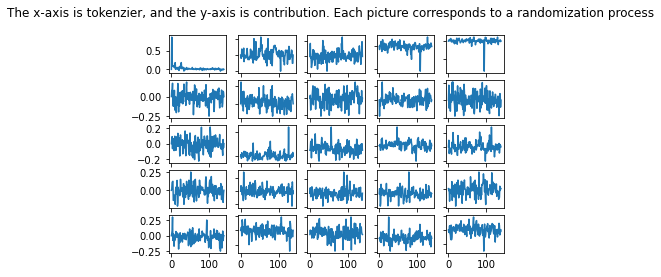

In [8]:
x_axis = range(len(random_attribution[0]))

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6,ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20),
      (ax21, ax22, ax23, ax24, ax25)) = plt.subplots(5, 5)
fig.suptitle('The x-axis is tokenzier, and the y-axis is contribution. Each picture corresponds to a randomization process')
ax1.plot(x_axis, random_attribution[0])
ax2.plot(x_axis, random_attribution[1])
ax3.plot(x_axis, random_attribution[2])
ax4.plot(x_axis, random_attribution[3])
ax5.plot(x_axis, random_attribution[4])
ax6.plot(x_axis, random_attribution[5])
ax7.plot(x_axis, random_attribution[6])
ax8.plot(x_axis, random_attribution[7])
ax9.plot(x_axis, random_attribution[8])
ax10.plot(x_axis, random_attribution[9])
ax11.plot(x_axis, random_attribution[10])
ax12.plot(x_axis, random_attribution[11])
ax13.plot(x_axis, random_attribution[12])
ax14.plot(x_axis, random_attribution[13])
ax15.plot(x_axis, random_attribution[14])
ax16.plot(x_axis, random_attribution[15])
ax17.plot(x_axis, random_attribution[16])
ax18.plot(x_axis, random_attribution[17])
ax19.plot(x_axis, random_attribution[18])
ax20.plot(x_axis, random_attribution[19])
ax21.plot(x_axis, random_attribution[20])
ax22.plot(x_axis, random_attribution[21])
ax23.plot(x_axis, random_attribution[22])
ax24.plot(x_axis, random_attribution[23])
ax25.plot(x_axis, random_attribution[24])

for ax in fig.get_axes():
    ax.label_outer()
fig.show()


def euclidean(p, q):
    # 如果两数据集数目不同，计算两者之间都对应有的数
    same = 0
    for i in p:
        if i in q:
            same += 1

    # 计算欧几里德距离,并将其标准化
    e = sum([(p[i] - q[i]) ** 2 for i in range(same)])
    return 1 / (1 + e ** .5)

for i in random_attribution:
    print(euclidean(random_attribution[0], i))



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()
Random_layer = ['bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.1.output.dense.weight',
 'bert.encoder.layer.1.output.dense.bias',
 'bert.encoder.layer.2.output.dense.weight',
 'bert.encoder.layer.2.output.dense.bias',
 'bert.encoder.layer.3.output.dense.weight',
 'bert.encoder.layer.3.output.dense.bias',
 'bert.encoder.layer.4.output.dense.weight',
 'bert.encoder.layer.4.output.dense.bias',
 'bert.encoder.layer.5.output.dense.weight',
 'bert.encoder.layer.5.output.dense.bias',
 'bert.encoder.layer.6.output.dense.weight',
 'bert.encoder.layer.6.output.dense.bias',
 'bert.encoder.layer.7.output.dense.weight',
 'bert.encoder.layer.7.output.dense.bias',
 'bert.encoder.layer.8.output.dense.weight',
 'bert.encoder.layer.8.output.dense.bias',
 'bert.encoder.layer.9.output.dense.weight',
 'bert.encoder.layer.9.output.dense.bias',
 'bert.encoder.layer.10.output.dense.weight',
 'bert.encoder.layer.10.output.dense.bias',
 'bert.encoder.layer.11.output.dense.weight',
 'bert.encoder.layer.11.output.dense.bias',
 'bert.encoder.layer.12.output.dense.weight',
 'bert.encoder.layer.12.output.dense.bias',
 'bert.encoder.layer.13.output.dense.weight',
 'bert.encoder.layer.13.output.dense.bias',
 'bert.encoder.layer.14.output.dense.weight',
 'bert.encoder.layer.14.output.dense.bias',
 'bert.encoder.layer.15.output.dense.weight',
 'bert.encoder.layer.15.output.dense.bias',
 'bert.encoder.layer.16.output.dense.weight',
 'bert.encoder.layer.16.output.dense.bias',
 'bert.encoder.layer.17.output.dense.weight',
 'bert.encoder.layer.17.output.dense.bias',
 'bert.encoder.layer.18.output.dense.weight',
 'bert.encoder.layer.18.output.dense.bias',
 'bert.encoder.layer.19.output.dense.weight',
 'bert.encoder.layer.19.output.dense.bias',
 'bert.encoder.layer.20.output.dense.weight',
 'bert.encoder.layer.20.output.dense.bias',
 'bert.encoder.layer.21.output.dense.weight',
 'bert.encoder.layer.21.output.dense.bias',
 'bert.encoder.layer.22.output.dense.weight',
 'bert.encoder.layer.22.output.dense.bias',
 'bert.encoder.layer.23.output.dense.weight',
 'bert.encoder.layer.23.output.dense.bias',
 'qa_outputs.weight',
 'qa_outputs.bias']


   #if name == 'bert.encoder.layer.21.output.dense.weight':
        #temp = torch.rand(1)

        #param.data[0] = temp
        #print(param.data[0])

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits


def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values


fig = plt.figure()
fig.set_size_inches(8, 6)

ref_token_id = tokenizer.pad_token_id  # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id  # A token used for prepending to the concatenated question-text word sequence


def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def predict_qt(question, text):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id,
                                                                cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'

    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)

    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens,


def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores,
            ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                        token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    # print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    # print("all tokens:    ", len(all_tokens))

    return all_tokens, attributions_start_sum


def get_posneg(all_tokens, attributions_start_sum):
    positive = []
    negative = []
    neutral = []
    for i, j in enumerate(attributions_start_sum):
        if j > 0:
            positive.append(i)
            # print('positive:',j)
        ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            # print('negative:',j)
            # print(all_tokens[i])
        elif j == 0:
            neutral.append(i)

    s_pos = ''
    s_neg = ''

    # print(len(attributions_start_sum))
    # print(len(positive))
    # print(len(negative))

    for i in positive:
        s_pos += all_tokens[i] + ' '
    # print("positive :", s_pos)
    for i in negative:
        s_neg += all_tokens[i] + ' '
    # print("negative :", s_neg)
    return positive, negative, neutral


def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[CLS]":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num + 1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num + 1
        else:
            temp.append(all_tokens[i])
    return sentence


def get_sence_score(sentence, attributions_start_sum):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = []
    for k, v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores = {}

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight += scores[word]
        delete_sentence.append(sum_weight)
        # print(sum_weight)
    return delete_sentence


def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = {}
    for k, v in sentence.items():
        # print(k,':',v)
        for i in v:
            sentence_value.append(i)
    # print(sentence_value)
    scores = {}
    # print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight += scores[word]
            delete_sentence[i] = sum_weight
    return delete_sentence


def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence


def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word
            rebuild_str += " "
    return rebuild_str


def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, = predict_qt(
        text, question)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask,
                                                 start_scores, end_scores, ground_truth, all_tokens, )

    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    return all_tokens, attributions_start_sum, end_score, start_score, [torch.argmax(start_scores), torch.argmax(
        end_scores) + 1], start_scores, end_scores


def max_min(x, y, z):
    max = min = x
    i = 1
    if y > max:
        max = y
        i = 2
    else:
        min = y
    if z > max:
        max = z
        i = 3
    else:
        min = z
    return (i)


def cycle_prediction(cycle_num, question, text):
    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(text,
                                                                                                              question)
    first_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
    first_answer = re.sub(r' ##', '', first_answer)
    print("my answer is ", first_answer)
    print(start_acc, end_acc)
    second_answer = ''
    sentence = separate_sentence(all_tokens)
    a = 0
    pos_contri = 0
    neg_contri = 0
    average_neg = []
    average_pos = []
    for i, j in enumerate(attributions_start_sum):
        if j < 0:
            neg_contri += j
        elif j > 0:
            pos_contri += j
    print("positive contribution:", pos_contri)
    average_pos.append(pos_contri)
    print("negative contribution:", neg_contri)
    average_neg.append(neg_contri)

    acc_s = []
    acc_e = []
    sun = []
    ans = []
    ans.append(first_answer)
    # print(start_acc, end_acc)
    acc_s.append(start_acc)
    acc_e.append(end_acc)

    for loop in range(cycle_num):
        sentence = separate_sentence(all_tokens)
        sentence_score = get_sence_score(sentence, attributions_start_sum)
        min_sensocer = 999
        min_index = 999
        for i in range(len(sentence_score)):
            if sentence_score[i] < min_sensocer and sentence_score[i] != 0:
                min_sensocer = sentence_score[i]
                min_index = i
        # print("should delete", min_index, min_sensocer)
        sentence[min_index] = ''
        sentence[1] = ''
        retext = ""
        for i, j in sentence.items():
            for words in j:
                retext = retext + words + " "
        li_sep = []
        for m in re.finditer(r"SEP", retext):
            li_sep.append(m.start())
            li_sep.append(m.end())
        retext = retext[li_sep[1] + 1: li_sep[2] - 1]
        retext = re.sub(r' ##', '', retext)

        all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(
            retext, question)
        reanswer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        # print(start_acc, end_acc)
        second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        second_answer = re.sub(r' ##', '', second_answer)
        # print("my answer is ", second_answer)
        ans.append(second_answer)
        # print(start_acc, end_acc)
        acc_s.append(start_acc)
        acc_e.append(end_acc)
        pos_contri = 0
        neg_contri = 0
        for i, j in enumerate(attributions_start_sum):
            if j < 0:
                neg_contri += j
            elif j > 0:
                pos_contri += j
        print("positive contribution:", pos_contri)
        average_pos.append(pos_contri)
        print("negative contribution:", neg_contri)
        average_neg.append(neg_contri)

        # print(acc_s, acc_e)
        # print(acc_s, acc_e)
    plt.plot(range(len(acc_s)), acc_s, label='start score')
    plt.plot(range(len(acc_s)), acc_e, label='end score')
    sun = []
    for i in range(len(acc_s)):
        sun.append((acc_s[i] + acc_e[i]) / 2)
    print(sun)
    plt.plot(range(len(acc_s)), sun, label='average')
    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()

    """"获取最好的曲线并输出"""
    max_start = 0
    max_end = 0
    max_ave = 0
    for i in acc_s:
        if i > max_start:
            max_start = i
    for j in acc_e:
        if j > max_end:
            max_end = i

    for x in sun:
        if x > max_ave:
            max_ave = x

    print(max_start, max_end, max_ave)

    max_list = max_min(max_start, max_end, max_ave)
    if max_list == 1:
        plt.plot(range(len(acc_s)), acc_s, label='Possibility')
        print(acc_s)
    if max_list == 2:
        plt.plot(range(len(acc_e)), acc_e, label='Possibility')
        print(acc_e)
    if max_list == 3:
        plt.plot(range(len(sun)), sun, label='Possibility')
        print(sun)

    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()
    """贡献的数值分别是多少"""
    plt.plot(range(len(average_pos)), average_pos, label='pos score')
    plt.plot(range(len(average_neg)), average_neg, label='neg score')
    plt.xlabel('Number of predictions')
    plt.ylabel('average contribution of pos/neg')
    plt.legend()
    plt.show()
    for i in range(len(ans)):
        print(ans[i], "pos/neg : ", -(average_pos[i] / average_neg[i]))
    average_contribution = 0

def random_model():
    text = """One of the first Norman mercenaries to serve as a Byzantine general was Hervé in the 1050s. By then however, there were already Norman mercenaries serving as far away as Trebizond and Georgia. They were based at Malatya and Edessa, under the Byzantine duke of Antioch, Isaac Komnenos. In the 1060s, Robert Crispin led the Normans of Edessa against the Turks. Roussel de Bailleul even tried to carve out an independent state in Asia Minor with support from the local population, but he was stopped by the Byzantine general Alexius Komnenos."""

    question = """When did Herve serve as a Byzantine general?"""

    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(text,
                                                                                                              question)

    attr_nomal = []
    for i, j in enumerate(attributions_start_sum):
        attr_nomal.append(j.item())
    print(attr_nomal)
    return attr_nomal

random_attribution = []
for i in range(int((len((Random_layer)))/2)):
    if i == 1:
        for name, param in model.named_parameters():
            if name in Random_layer[0:i*2]:
                param.data = torch.rand(param.size())
                model.to(device)
        random_attribution.append(random_model())
        print(i)
    if i != 1:    
        for name, param in model.named_parameters():
            if name in Random_layer[i*2 -2:i*2]:
                param.data = torch.rand(param.size())
                model.to(device)
        random_attribution.append(random_model())
        print(i)
print("随机的贡献分别都是：", random_attribution)


Question:  When did Herve serve as a Byzantine general?
Predicted Answer:  105 ##0s
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.8690725593657715, 0.2337344599471851, 0.08005030041046007, 0.08864003335387671, 0.09622049285690962, 0.07697813848835218, 0.07482073658094374, 0.04559544460193606, 0.10520598097002073, 0.18155816811190606, 0.0, 0.05300490888385318, 0.030023930870179124, 0.022066999182590766, 0.010587985860722043, 0.005653058476815085, 0.029871337975542242, 0.05863688385867519, -0.00043634941859846974, -0.02862715562418831, 0.00852400385887852, 0.045736538819464496, 0.08791900854101879, 0.0395702148870914, 0.1043501888558295, 0.1829468583847028, 0.023088798383675273, 0.018909515327637526, 0.030915791248510485, 0.060988844692462595, 0.02191176346857275, 0.04448626623573387, -0.044658809874091834, -0.00106241259290115, 0.03263529624756706, -0.014580989233784064, 0.007146297453800516, 0.0013162197297505488, 0.02254904430500845, 0.049720185360321606, 0.02409861623425201, -0.0032579464446175835, 0.02268272989247543, 0.024725443083509987

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.02483288764680014, -0.2093826975794252, -0.06227659422432777, -0.01698808756785243, 0.13171087514791865, 0.18890971332723205, 0.05710753615325369, 0.0015477811613108076, 0.07362405930829774, 0.062281608977968916, 0.0, 0.1189212395831873, 0.12083853363306277, -0.026008530454345754, -0.04294716111762959, -0.021429348606430306, 0.13383754600916384, -0.07426518667853266, -0.0690674375593305, 0.12648888705759487, 0.03732592718658614, 0.05782717720109415, -0.04148173134764248, 0.07504538837926741, 0.057557385190500916, -0.008809398248409171, 0.05997339962476725, 0.09019463296287648, 0.1972175724306654, -0.0354189496660171, 0.09057632036355008, 0.1118275839215099, 0.03210306155972043, 0.12631298660802212, 0.1301307389273421, 0.0935098059466091, -0.033759412778242855, 0.24178373637102282, -0.01431206500783983, 0.06356986037493255, 0.01772396187257087, 0.05363469027602224, 0.01994145697833132, 0.09746854002883988, 0.125654

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.0004699258975120035, -0.08383283424706314, -0.12444012472894134, -0.05039102325951443, -0.0398503569638365, -0.04337470687910245, -0.019828417930441652, -0.015664912682174285, 0.15315195349949023, -0.26949530872992283, 0.0, -0.09750437377748875, -0.13646800402424222, -0.14604329429186355, -0.00324358367113996, -0.11768058282880758, -0.06889613148396519, -0.07253469358087515, 0.019255410088189633, -0.1132252267102494, -0.013857004688146515, -0.03300404781806882, 0.05383731653402088, -0.09957000162666095, -0.06916559393736103, -0.04913381307284363, 0.027781021275418337, -0.0012689074773134163, -0.04565025510359984, 0.015009622839866387, -0.11761512416555656, -0.06833906070095562, 0.038204365667492066, 0.11302142486357483, -0.04976628381404465, -0.022388721296353567, -0.03603139915333603, -0.10589711636797829, 0.00586163500456433, -0.14789809716374974, -0.013183329454590699, 0.17240584459751188, 0.061863252025075706,

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.3079411529442771, 0.1418318860303071, -0.005682502478589857, 0.04447850478076653, 0.07617288369702269, 0.13731288611408976, -0.05284082058171979, 0.005942526719765114, 0.06355012338855687, 0.09254052064167907, 0.0, 0.021397410979648517, 0.01460368006387753, 0.1140425612593518, 0.0022040534494890793, -0.15216287690514335, 0.019011459099744464, 0.17448760647749348, 0.06646440861599712, 0.041566749555479385, 0.06120067044147933, -0.10773365200189404, -0.18212575904656475, -0.19654918362165846, -0.00908198838423907, -0.027463663274539623, -0.015406032093389848, 0.024556282809593783, -0.04511470133103566, -0.008049417486239129, 0.005387621698831026, 0.0072458371913365046, -0.027236455229789572, 0.11085741236400576, 0.13227302358679763, 0.005016404215223551, 0.04169090963841882, -0.05884774752983481, 0.06052774124643559, 0.06740611644981839, 0.004139083304471249, -0.0005211714747057464, 0.029538230037638485, -0.00885246

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.21710235940595518, -0.13917708386986324, 0.06876242000809482, 0.19962910413276796, 0.048268883134365524, 0.040185288927524286, -0.08517650426150561, -0.016495738080123272, -0.051716799636232366, 0.0024477925861348753, 0.0, 0.09186603476668002, -0.11555483057424103, 0.03342923950991701, 0.012390503013173147, -0.07612158314766544, 0.22164722499372636, 0.07894257098014014, -0.005480205447910214, -0.08323815541081354, 0.08105170342740825, -0.04141567685774105, 0.00660454750989003, 0.0730100833496049, 0.05666460571648088, 0.10166928163782843, 0.0967366405280027, 0.11651328677195892, -0.0671653083312816, 0.22737423119448338, 0.06728363146464975, 0.020802342030825156, 0.08928472484029125, 0.07303681125985328, 0.030695563533437702, 0.1817893442805703, 0.20749575639779655, -0.09088307270024576, -0.09443015045591496, 0.04464503925863761, -0.03688401745262369, -0.053485196581503726, 0.20470256566909587, -0.097600844380549, 0

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.05766586107835696, 0.09445126032561948, 0.03231256794166022, -0.009490977714112945, -0.025090455448204065, -0.05088066906945469, 0.08152283515985759, -0.06263448203969665, 0.0037239468344042654, -0.03913802494399817, 0.0, -0.017528886135472772, -0.051379715279614276, 0.06831688936970316, 0.08151352863332804, -0.006228866224245731, -0.04180857927304614, -0.018521211089817764, -0.060211723077200456, -0.0968541862611762, 0.08574882950485811, 0.038663243341532, -0.003241532351802799, -0.1300066639753763, -0.04379376878548228, -0.02236383014263074, 0.06695979406289801, 0.09077042059766785, -0.11067164619953312, -0.14857398844038264, -0.0882436126679802, -0.05429330108725231, -0.06981592818780598, 0.06807884759723065, 0.009430483811283308, 0.08210028111747839, 0.018529443750259344, 0.14470646645366358, -0.031988196488277804, -0.07329404618649454, -0.051327710134919304, -0.08816276286522196, 0.02633476910486691, -0.01720

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.108101223127156, 0.10979054736074349, 0.016627219709472712, 0.1320688846122079, -0.016689775204784246, -0.1596477963153637, -0.16686107963551863, -0.03183501540989566, 0.11474056559265454, -0.05486820942877775, 0.0, -0.08239514055938468, -0.0564745330250984, 0.13542507077872915, 0.05485164912817577, -0.029948278972935317, -0.10350513440316846, -0.0005389603613524886, -0.12720772857683577, 0.02288806295660407, 0.062178164929403174, 0.0821196389467496, 0.10631043168839849, -0.027764598454050046, 0.13121435553212688, 0.03582442964924404, 0.05969388808688434, 0.07636613565774372, -0.04383244169374179, 0.023046745342697385, 0.17511159887891983, 0.06421246070419047, -0.012318212000482597, 0.11344427790962731, 0.06749468017394293, 0.04005397029255427, 0.04839024782393637, -0.11405203195307063, -0.05832923289029213, -0.004927752076078276, 0.06053612207061812, -0.19248125724084267, -0.06670784245613534, -0.0477675880815804

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.09812795950519083, 0.033790514633628796, -0.06302949109706028, 0.05928827721609714, -0.0954212396011017, 0.055879062822173524, 0.0775870211216601, 0.1588653795205503, 0.12683836367487142, 0.21573097051835616, 0.0, -0.03291612055002737, -0.0295505367356639, -0.025014034909692673, 0.05341403204975555, -0.013262985768156548, 0.24166181234278025, 0.013273474640780512, 0.009388695689372652, 0.08006154767384953, -0.005626960283896233, -0.027893479235534643, -0.11852960886433773, -0.07943997289285627, 0.11682437595891762, -0.05750014443614479, 0.015588473407459025, -0.08139371624430654, -0.053501120061336754, -0.12834627660590403, -0.13992296114998554, -0.050894713725449646, 0.026777199725553376, -0.23469447523684542, 0.09554985285470623, 0.012468923840903222, 0.055635631878708056, 0.0988261075273392, -0.13315717373365363, 0.16775681330832928, -0.10324767171947366, -0.05096451128809339, -0.13749015665811995, 0.093323951

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.10504584859768684, -0.008790854922542515, 0.06050447392319622, 0.0015231045699219397, 0.06278141588443516, -0.05012207792663346, 0.09567018629735276, -0.030921292175788956, 0.055616233976671675, -0.06864127673339951, 0.0, -0.025885425581790116, -0.041565607108419944, -0.07870291598776925, -0.005636570344022368, -0.08820744121186617, -0.12187816833783661, -0.033293810756268846, 0.00912969580157566, -0.04925285798543863, -0.04786194197927936, -0.06534893020034696, 0.12629456315337845, 0.012048961391786355, 0.14234249510708352, 0.06740972885833439, -0.05805748992934923, -0.01724026575382699, -0.03716754663040431, -0.07921843930091457, -0.02105823160565078, 0.09672272927434283, -0.19537945123609018, 0.07578572577050471, 0.10476483585170868, -0.002089964205047914, 0.06981781395215662, -0.016542883495142123, -0.07200647736081801, -0.0467496111908558, -0.04062964624750284, 0.1114159859480159, 0.09239668822314637, -0.0380

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.14632084226755332, -0.028171518461611072, -0.01068962452262138, -0.1264714272973209, -0.25777891011217846, -0.0016580490227960385, -0.010323369997888687, -0.012640810937751396, -0.021584382648307147, -0.039886844492032496, 0.0, -0.032525295908941765, -0.06027445143733444, -0.024075353166009183, 0.011138594463744815, 0.06627356210492692, 0.034073234992887724, -0.20026536836435285, -0.21434174099318673, -0.06975913306231342, -0.05322860599645061, -0.010978806682878418, -0.05866721450504603, -0.037720139433320476, -0.08245801813170961, -0.09497554410528092, 0.058920822109767255, -0.02830126033909658, -0.01639572769584382, -0.03976145170026098, 0.052875115196279146, -0.03208504431335943, 0.01342929582707318, -0.01499994699354737, 0.07652856946971043, 0.009871001031059992, -0.06620015124493048, 0.019547701413659784, -0.008959403923577929, -0.1256283227132391, 0.08106070329828584, -0.002729568706220442, 0.1247054420356

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.037896616055178446, -0.08101799917271778, -0.18262416014989097, -0.024122350768829515, 0.2477856948410331, 0.0035003746636522257, 0.049328035364038396, 0.016450328777108628, -0.1852708353874398, 0.03171252406311161, 0.0, 0.12568497101141818, 0.1091138546834848, -0.04435278638218901, 0.020139091778289465, 0.07340627731883961, 0.022858070640098406, 0.02822201521168052, -0.07922968907848976, 0.11003356218875344, 0.10608197184629693, -0.11207435003851508, -0.08920702385830735, 0.028653601519556572, -0.0752312352033299, 0.16541468947759552, -0.11454903067456744, 0.08802289813129692, 0.0817698553956574, -0.021744452364634997, -0.057978002911116454, -0.12533015691244867, -0.04097831879624817, -0.048188458834590754, 0.08731930307132231, 0.025193809599673236, 0.012907017604541772, -0.001158755578013041, 0.024655424522236142, 0.13795787543707425, 0.009302536239248382, -0.04358110444578502, 0.01157211041460523, 0.1502303313

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.08189600888178337, -0.026164852129458786, -0.022148288953337206, -0.10459956709526047, -0.07430463391605592, -0.08707635274473403, -0.05858860934094349, -0.30298094463368386, -0.08151687819873528, -0.10920645525443111, 0.0, -0.01724262609162416, -0.013372365207090654, 0.03223221739508544, 0.0012423332552218493, -0.01209061971286415, -0.0804927165810863, -0.027004600320479508, 0.3614543984707391, 0.031103086173582997, -0.10149582198272976, 0.05185252822519338, -0.004302415770964573, -0.005057437157097173, -0.07573599750593793, 0.025843947331747136, 0.06173213980065852, -0.04077556974253836, -0.0008407436095508162, -0.06121002875069514, 0.0828245676784998, 0.022796196387893465, -0.1270227517772597, 0.101162674074023, -0.04688497108625429, 0.20759368107631054, -0.0055750571233008465, -0.05666421513708582, 0.08881196115761356, 0.00010119028920591551, 0.11431023529827075, 0.05791401150410656, -0.03302344863924406, 0.0

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.035136179745443925, -0.0493155699654938, 0.02429251742661694, -0.01466585622759282, -0.05519819465727477, -0.037965060098333295, -0.023376600766366863, -0.05030023299646822, 0.04076781213489151, 0.07775033180325877, 0.0, -0.041848888877984755, -0.013013344796303053, -0.01188507132752899, -0.038509980648056816, -0.07867533866303704, 0.06788794000580926, -0.001965983742376658, 0.056354581916662774, -0.06567295706481832, -0.05922689153128242, 0.050281945294123234, 0.6372625338901625, -0.11023108590140016, 0.1379845006362756, 0.10538847303624811, -0.026256760240972742, 0.11330864495235725, -0.08530822147951787, 0.11876923137756157, 0.03427526381952018, -0.013093242991089214, 0.08288468659439505, 0.016701565004921703, -0.13151543912668892, -0.005607499117308294, 0.014812983522554639, -0.04923629093905696, -0.12583631609081317, -0.050802977942100605, 0.012779960950836134, -0.041585938569810285, -0.060905309987085904, -

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.2740698946593346, 0.17067117561771727, -0.012144427425175094, -0.029909767779074777, 0.03136105328490161, -0.2276645014463578, 0.0037215155159258176, -0.015260293101025328, -0.20433068240023294, -0.021471357890558332, 0.0, 0.002756169396927113, 0.007520542223708696, -0.007248833715023867, 0.04633288197484868, -0.09094948740413625, 0.03609165156751622, 0.028721585475365963, 0.04538315249814448, -0.006132236063542871, -0.03257244173212262, 0.004759642891674805, 0.08842813154536841, -0.007659414776862007, 0.08649378515283365, -0.031569006936938496, 0.030586781483174286, -0.030462965936165678, -0.023090602635057307, 0.05648505803419415, -0.05030649056361237, 0.041337262678609675, 0.06284180462177158, -0.1128442274286615, 0.27080520043060186, -0.19382518725711204, 0.030934540529141595, -0.049135029917597696, -0.011408743841730214, 0.03673463623733785, 0.029735255453531183, -0.0682567874769868, -0.02029947153421079, 0.0

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.056919775397479944, -0.0729112866229382, -0.03522650946286079, -0.057167575332632746, 0.08197194196111464, -0.021497229421311596, -0.009590451092742381, 0.01746510067371419, -0.11372011904186721, 0.03851486931372346, 0.0, 0.008868645473559008, 8.75620623346751e-05, -0.06436441389561874, 0.10934181772672573, 0.11941334088235271, -0.10071081814870717, -0.009145993926868873, -0.016651988482801024, 0.0709965374886661, -0.10973601356246314, -0.001166106935193109, -0.05311442888287669, -0.06386470145055138, 0.04753555701756482, 0.03218955241515562, -0.011888899978428189, 0.06539035163921486, -0.07301491269286528, -0.006417620529928575, -0.12147386840725385, -0.004644736610968126, 0.1511928681193552, -0.08518615288687735, 0.06506114836733409, -0.04761213035501885, 0.0690449640591494, 0.021275191767469524, 0.12170722865751726, -0.1134287913499123, 0.038577982613864456, 0.013652045077444448, -0.07984954675869142, 0.0171025

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.05448875690895705, -0.08205021461533961, -0.17554178324273387, -0.06918286647823936, 0.051891266809217886, 0.10183734594162862, -0.030980807357457937, 0.3020361661393838, 0.02802916082485448, -0.10827729924333576, 0.0, 0.04319582231168199, -0.0037779452639792144, -0.036253309562308676, 0.13341734526646618, 0.11259907828072482, -0.15570687164472316, -0.032919684247091914, -0.04771548999316686, -0.08356991150464142, 0.10855420394170741, 0.13638609517214778, -0.10019091783588512, 0.12822703163731405, 0.03318424688103073, 0.1001376002768918, 0.001227107651478036, -0.02061961586920861, 0.019453800694422298, 0.09096114857445926, -0.026403425631473503, 0.028960553037077598, -0.1222306532932881, -0.009358270102179806, 0.005059415067861946, 0.029102077703526717, -0.08372239211050199, -0.01749829299399011, 0.15277292052940927, 0.007855368574270556, -0.058089503361050294, -0.10622691243209872, 0.014404088881433547, 0.0280929

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.06805408143309738, 0.066906884607446, -0.04627369920784143, -0.02014822093483398, -0.05572675046622254, 0.060879158238731884, 0.02657669388756772, 0.06622865448220842, -0.08370059116609216, -0.04639954370966037, 0.0, 0.018771214030632328, 0.10743990030711932, 0.025603690144964105, -0.07950308355949487, 0.1561166195345355, 0.12039268586757067, 0.016203769721925543, 0.0896186454876116, -0.05874712401376523, 0.05118838122946276, 0.038673124500761484, -0.03930858634948022, 0.070004504721947, -0.17164771916302635, -0.042785715812582045, 0.024214592677336246, 0.09199488687769963, -0.031977989987488006, -0.20633943841761948, 0.021912664074166074, 0.11945467179955006, 0.02301266516966377, 0.005697885876681952, -0.041229269965080986, -0.020885094223021032, -0.008987167347927991, -0.13424789869283113, -0.04986289428837985, 0.047878697303299536, -0.023435097752438145, 0.07224573477367428, 0.0569451280061142, -0.0679005962933

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.051777025299717415, 0.01789937443110834, 0.05358613545609817, -0.0957138379883798, 0.15301669849283514, -0.09533567225480732, -0.12481698382492697, -0.1202847393426598, -0.06633578244342353, -0.10286106736232338, 0.0, -0.018122677523422892, -0.05460064852650321, -0.06381354700650999, -0.1352039439737476, 0.021877148144832673, -0.2099086776341688, -0.06333029277254303, 0.08633681739164265, 0.004187765027315079, 0.000901894588610638, 0.047975913836487305, -0.033150259845071535, -0.09845717052401633, 0.0593573247907343, 0.02627545954729017, -0.003924661269179293, -0.04493849860851757, 0.042434504506257395, -0.030298192380564082, -0.017843200157912145, -0.05932207967742129, -0.021934323393931, -0.004478880445848229, -0.09682510799702855, -0.03710816292017128, -0.06277872650908428, -0.06735121365690189, 0.166728956821762, -0.21887679689775896, 0.15620508483295414, 0.03442125221355728, -0.1003042516272022, -0.062423817

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.005826851203598171, 0.031344709338289735, 0.12303286802621846, -0.0715814844460821, -0.2896385451754497, -0.1319389765059832, -0.029685034142820425, -0.12791140750104749, -0.010645326487112671, -0.08120800927606626, 0.0, -0.05242148099691848, 0.004060805868775076, 0.00856351393305228, 0.046512237696131734, -0.14077751089783308, -0.11228828451140285, 0.005268031181712393, 0.021813469379174794, 0.03364691579468927, -0.10936964559072306, -0.062046443385332294, -0.0035583039846301292, 0.04100906031631293, -0.13387045922438712, -0.2639193747787184, -0.002423066525739411, -0.08393410225725079, -0.005767389909669647, 0.002005009606676993, 0.07610965113578584, 0.07832170575389676, 0.008927669455441427, -0.08767891898369262, -0.05548914502999654, -0.06766612012620724, 0.03213727718050037, -0.1541960186631054, 0.19681878357402027, 0.23421838264631895, 0.00810893397066154, 0.10689066987535054, -0.016304044589233718, -0.00699

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.05799957096729237, -0.06014151616774476, 0.13217439503512482, -0.10611946572203722, -0.0025658688899995383, 0.036599686992784486, 0.019616491421717903, -0.016837892789289488, 0.0464278801846662, -0.00672512573218633, 0.0, -0.015614037034098385, -0.049298268115122175, 0.04337572180589214, -0.011411797630312122, -0.04616089492894233, 0.02985714927813772, -0.04712064940868149, -0.0804416922802858, 0.055881516944691276, -0.04513080688820689, -0.03955442779377367, 0.4505701864286508, -0.0532825093602619, 0.05483224521798676, -0.03144142007314505, 0.0654039101663789, -0.04128910243888564, 0.005601672570052383, -0.10558835663254351, -0.05288117532344424, -0.1419541127391188, -0.019067959813957664, 0.05609429966209938, 0.0376902264068872, -0.06298114056504465, -0.055848363440255774, -0.010701159121517019, -0.08646069228071045, -0.07621902270116616, -0.0012504572036270499, 0.0017769521504998175, 0.05439717111434536, 0.040

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.11367624878669694, 0.020880719509058353, 0.007032545419286979, 0.08035111581605758, -0.139327486088949, -0.05840088329714232, 0.025346622428300533, -0.03907613544000301, 0.10624781554528204, -0.10031304085936282, 0.0, -0.05305621240643129, -0.036912479262055584, -0.06977522936806779, 0.24524267821869536, 0.04659580478557781, -0.002433643772469719, -0.03814955592708503, -0.06532393890170046, 0.07650025617631569, 0.019870039413466704, -0.043732774751215286, 0.017966287006720316, -0.06582784265460455, -0.0015789571796646375, -0.0858698082684631, -0.02972474984092445, 0.09638153250185331, -0.016902128966864476, 0.058419878480969044, -0.0128695240393005, 0.038692767434000026, 0.06290126545879275, -0.06243642773642559, 0.0561488189708472, -0.027633381678630477, 0.009946608306561114, -0.013440605873269186, 0.054551744232628464, -0.12779388264911318, -0.14059548478485498, -0.01629838195380438, -0.07541903725160728, 0.244

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.21899275852663644, 0.19025429061478183, -0.03970548629370361, -0.04699501913154914, -0.07034850232282851, -0.08287080482674464, 0.0811445461732135, 0.14610697900986255, -0.0016602728339784967, 0.023013099030296292, 0.0, -0.0900403994899516, 0.032006431012671456, -0.011260276904582974, 0.1001790402042391, 0.024245289986076984, -0.0890898034340892, -0.10330099148555298, -0.14192734276005445, 0.030629719224829002, -0.09112179658996111, -0.09888050950298784, 0.10550805296441534, -0.032273555038376714, -0.08155479365671867, -0.04598861275542523, -0.022016718265071233, 0.030742175123439113, 0.0793982273831035, 0.01758478708226791, -0.08327547702597388, 0.03037797592360222, 0.13327741347537253, -0.011308681691503694, 0.002186497821968188, 0.13163092221362868, 0.03532056924392178, 0.06417136353597183, -0.07910020081086713, 0.04365208082314081, -0.09436758203972057, -0.1892992621169592, 0.04381304635844776, -0.039429011533

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.00611517736624516, -0.109556201418753, 0.047737195748117314, 0.02437809013689117, -0.03670214203526931, -0.045689294342564704, -0.026802433574884568, 0.07446840877557247, 0.013657986525103364, 0.045530479300933006, 0.0, 0.004097330731276244, -0.020458119703417696, -0.037140472736379694, -0.0030373963965284086, -0.21699351828018504, 0.04179703891790026, 0.03623606876062388, -0.04560025507030083, -0.09795469385773252, 0.07167174989705291, -0.07467487319525863, 0.10517457158210801, -0.018221274347599962, -0.33468187488885826, -0.16279894137023695, 0.018927720503831093, -0.07493601628233389, 0.06571217447252418, -0.13639621045938952, -0.03814479036071838, -0.0948579845079185, -0.10841002043973724, -0.02831621826021113, 0.05650483266706802, -0.012058330695242194, 0.08943725004794079, 0.0527934921726951, 0.06534445036227278, 0.028631579757358493, -0.05524470505274849, -0.08661456613060278, 0.113614272048002, -0.1147059

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, -0.0043171620596835734, -0.07354104103508753, -0.1845302819884242, -0.127860496764294, -0.08093553829396158, 0.08638973688476392, -0.05913391016534966, 0.12037655152474126, -0.07702367367287152, -0.02354180362631966, 0.0, -0.049397999667227334, -0.014189188108356478, 0.05629540007510084, 0.11747878168669008, 0.15767333192346047, -0.08537292646874879, -0.05938089524173826, 0.07563108728455925, 0.07745736441032702, -0.004588245009063262, -0.05948871120213602, 0.02867968613348516, 0.14771090923872068, 0.06666004971365634, 0.08675910630030016, 0.09563081142222697, -0.010652890286966216, -0.0005121759098731892, -0.09938634770290741, 0.025941790568728106, -0.006662134375477776, -0.1167207890427425, -0.007621924033801739, 0.011864095100235167, 0.04675824647723962, -0.039691211366733, 0.09125815383054652, -0.03487547793441183, -0.10761712425494052, 0.13450786100624115, 0.015572716246651687, -0.0006791413741437011, -0.080424

 Visualizations For End Position 
attributions_start_sum:    139
[0.0, 0.09086114688937992, -0.13449652084852026, 0.023503051195391474, -0.11885479101039473, -0.08910399137730456, 0.055437079454979735, -0.0017516890548212307, 0.14014996208649777, 0.01907231604135879, 0.11402754899746013, 0.0, 0.07461844676071214, 0.024397538869265403, -0.07668132057888657, -0.031223425852662388, -0.00902789388875009, -0.014621305235402254, 0.0442221619997326, -0.06863917815102774, -0.1424574513623128, -0.06123987678844116, 0.14198587590295902, -0.052257710118059436, 0.07983086733282202, -0.10680721028239046, 0.10250070531324726, 0.07942800001813889, 0.13470237866039997, 0.03246717854415103, 0.18313782816749768, -0.11358553684364497, -0.02251778207276413, 0.033000179495147476, 0.09229623015244354, -0.031561522421341685, -0.023235433422875578, -0.002771906628879798, 0.0346589465005042, -0.07079039431096541, -0.0799096662894099, -0.018482911940605702, 0.012939157507658335, 0.054034336931458773, 0.07617798

<Figure size 576x432 with 0 Axes>

D:\software\Anoconda\envs\xai\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


1.0
0.5612868221608761
0.5267457576471914
0.5191679651744288
0.5405542105741092
0.5197277136480611
0.4902345506552967
0.5439431742241798
0.5142005434893152
0.5426757751216046
0.47830380709884274
0.5328568633871256
0.5002493262091657
0.5292661871960265
0.5738076108952375
0.5145169920115545
0.532044831494488
0.5320838443979672
0.545528912072852
0.4885401293495823
0.5387959298498513
0.5373828639573321
0.5513033068060076
0.5259258294074995
0.5006946318880476


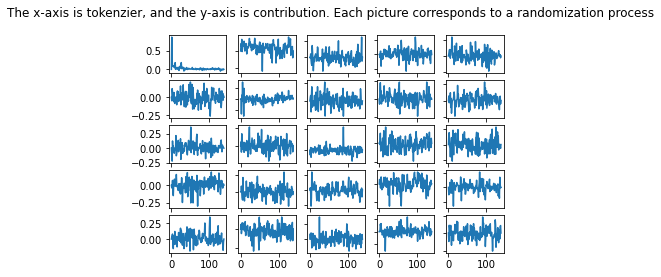

In [11]:
x_axis = range(len(random_attribution[0]))

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6,ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20),
      (ax21, ax22, ax23, ax24, ax25)) = plt.subplots(5, 5)
fig.suptitle('The x-axis is tokenzier, and the y-axis is contribution. Each picture corresponds to a randomization process')
ax1.plot(x_axis, random_attribution[0])
ax2.plot(x_axis, random_attribution[1])
ax3.plot(x_axis, random_attribution[2])
ax4.plot(x_axis, random_attribution[3])
ax5.plot(x_axis, random_attribution[4])
ax6.plot(x_axis, random_attribution[5])
ax7.plot(x_axis, random_attribution[6])
ax8.plot(x_axis, random_attribution[7])
ax9.plot(x_axis, random_attribution[8])
ax10.plot(x_axis, random_attribution[9])
ax11.plot(x_axis, random_attribution[10])
ax12.plot(x_axis, random_attribution[11])
ax13.plot(x_axis, random_attribution[12])
ax14.plot(x_axis, random_attribution[13])
ax15.plot(x_axis, random_attribution[14])
ax16.plot(x_axis, random_attribution[15])
ax17.plot(x_axis, random_attribution[16])
ax18.plot(x_axis, random_attribution[17])
ax19.plot(x_axis, random_attribution[18])
ax20.plot(x_axis, random_attribution[19])
ax21.plot(x_axis, random_attribution[20])
ax22.plot(x_axis, random_attribution[21])
ax23.plot(x_axis, random_attribution[22])
ax24.plot(x_axis, random_attribution[23])
ax25.plot(x_axis, random_attribution[24])

for ax in fig.get_axes():
    ax.label_outer()
fig.show()

for i in random_attribution:
    print(euclidean(random_attribution[0], i))


# 计算欧几里德距离

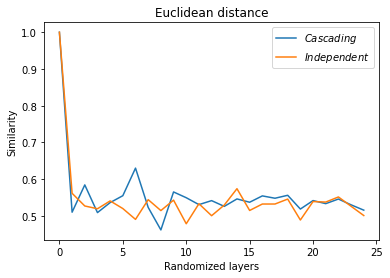

In [23]:
a = [1.0,
0.5098335352107783,
0.5841374468651795,
0.5087017825606004,
0.5359863500813522,
0.5547434974031893,
0.6298511427209301,
0.5228628263407851,
0.46153117156884044,
0.56494047052406,
0.5492439018634194,
0.5304611144622997,
0.5413131501748248,
0.5256437642709116,
0.5459381057418031,
0.5369210075878097,
0.5542138216270899,
0.5478105815273872,
0.5558675530303803,
0.5183833309690906,
0.5414733159446335,
0.5331040340860408,
0.5456539010929875,
0.529830669263156,
0.515353079292645]
b = [1.0,
0.5612868221608761,
0.5267457576471914,
0.5191679651744288,
0.5405542105741092,
0.5197277136480611,
0.4902345506552967,
0.5439431742241798,
0.5142005434893152,
0.5426757751216046,
0.47830380709884274,
0.5328568633871256,
0.5002493262091657,
0.5292661871960265,
0.5738076108952375,
0.5145169920115545,
0.532044831494488,
0.5320838443979672,
0.545528912072852,
0.4885401293495823,
0.5387959298498513,
0.5373828639573321,
0.5513033068060076,
0.5259258294074995,
0.5006946318880476,]

X = range(len(a))
Y1 = a
Y2 = b
plt.plot(X, Y1,  label=r"$Cascading$")
plt.plot(X, Y2,  label=r"$Independent$")
plt.xlabel('Randomized layers')
plt.ylabel('Similarity')
plt.title("Euclidean distance")
plt.legend()
plt.show()

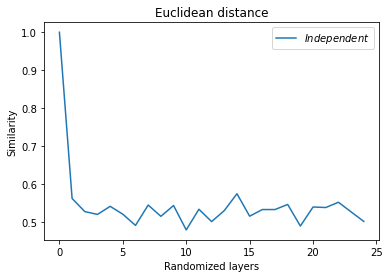

In [25]:
a = [1.0,
0.5098335352107783,
0.5841374468651795,
0.5087017825606004,
0.5359863500813522,
0.5547434974031893,
0.6298511427209301,
0.5228628263407851,
0.46153117156884044,
0.56494047052406,
0.5492439018634194,
0.5304611144622997,
0.5413131501748248,
0.5256437642709116,
0.5459381057418031,
0.5369210075878097,
0.5542138216270899,
0.5478105815273872,
0.5558675530303803,
0.5183833309690906,
0.5414733159446335,
0.5331040340860408,
0.5456539010929875,
0.529830669263156,
0.515353079292645]
b = [1.0,
0.5612868221608761,
0.5267457576471914,
0.5191679651744288,
0.5405542105741092,
0.5197277136480611,
0.4902345506552967,
0.5439431742241798,
0.5142005434893152,
0.5426757751216046,
0.47830380709884274,
0.5328568633871256,
0.5002493262091657,
0.5292661871960265,
0.5738076108952375,
0.5145169920115545,
0.532044831494488,
0.5320838443979672,
0.545528912072852,
0.4885401293495823,
0.5387959298498513,
0.5373828639573321,
0.5513033068060076,
0.5259258294074995,
0.5006946318880476,]

X = range(len(a))
Y1 = a
Y2 = b
#plt.plot(X, Y1,  label=r"$Cascading$")
plt.plot(X, Y2,  label=r"$Independent$")
plt.xlabel('Randomized layers')
plt.ylabel('Similarity')
plt.title("Euclidean distance")
plt.legend()
plt.show()